# BANDITS VS AB

In [1]:
import  os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
    
from bandits import ThompsonBernoulli, ThompsonGaussian, UCB1, EpsilonGreedy

In [3]:
# Simulate user stream
np.random.seed(42)
n_users = 5000
true_conversion = [0.12, 0.15, 0.18]  # three arms
true_gpv = [100, 105, 110]            # GPV per arm for ThompsonGaussian
n_arms = len(true_conversion)

# Generate user-level context
users = pd.DataFrame({
    'user_id': np.arange(n_users),
    'country': np.random.choice(['US','IN','UK'], n_users),
    'device': np.random.choice(['desktop','mobile'], n_users),
    'traffic_source': np.random.choice(['organic','paid'], n_users)
})

In [4]:
# Initialize policies
policies = {
    'ThompsonBernoulli': ThompsonBernoulli(n_arms),
    'ThompsonGaussian': ThompsonGaussian(n_arms),
    'UCB1': UCB1(n_arms),
    'EpsilonGreedy': EpsilonGreedy(n_arms, epsilon=0.1)
}

In [5]:
# Run simulation
results = {}
for name, policy in policies.items():
    cumulative_reward = 0
    allocation = np.zeros(n_arms)
    rewards_list = []
    
    for idx, user in users.iterrows():
        arm = policy.select_arm()
        # Bernoulli reward
        if 'Bernoulli' in name:
            reward = np.random.binomial(1, true_conversion[arm])
        else:  # Gaussian reward
            reward = np.random.normal(true_gpv[arm], 10)
        
        policy.update(arm, reward)
        cumulative_reward += reward
        allocation[arm] += 1
        rewards_list.append(cumulative_reward)
    
    results[name] = {
        'cumulative_reward': cumulative_reward,
        'allocation': allocation,
        'reward_trace': rewards_list
    }

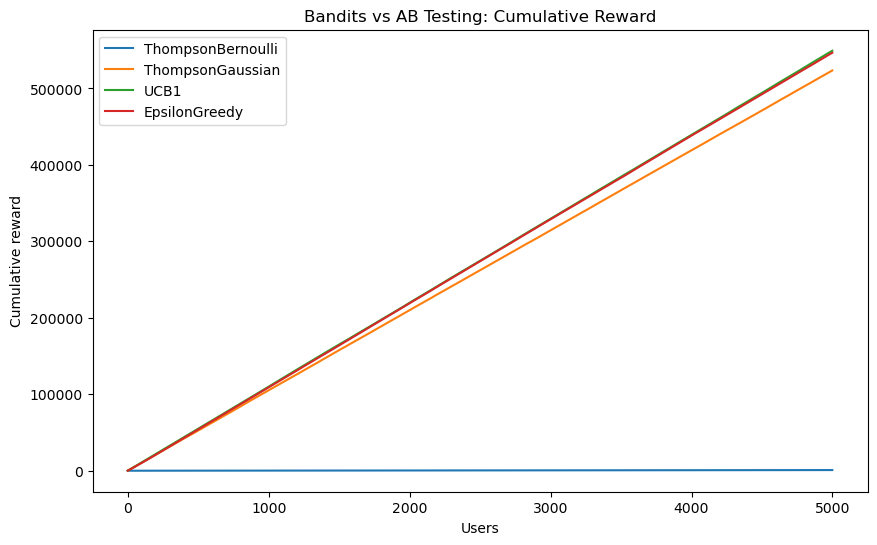

In [6]:
# Plot cumulative reward
plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.plot(res['reward_trace'], label=name)
plt.xlabel("Users")
plt.ylabel("Cumulative reward")
plt.title("Bandits vs AB Testing: Cumulative Reward")
plt.legend()
plt.show()

Allocation share per policy:
   Arm  ThompsonBernoulli  ThompsonGaussian    UCB1  EpsilonGreedy
0    0             0.0560               0.0  0.0002         0.0454
1    1             0.1346               1.0  0.0002         0.0318
2    2             0.8094               0.0  0.9996         0.9228


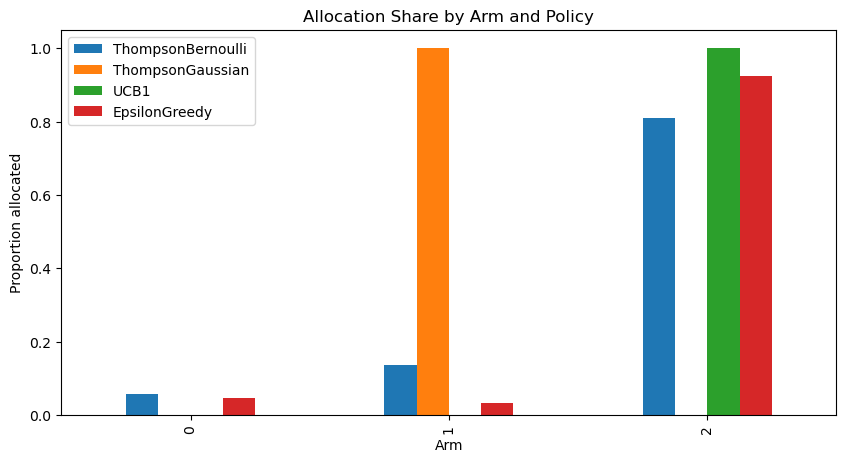

In [7]:
# Allocation share
allocation_df = pd.DataFrame({
    'Arm': np.arange(n_arms),
})
for name, res in results.items():
    allocation_df[name] = res['allocation'] / res['allocation'].sum()

print("Allocation share per policy:")
print(allocation_df)
allocation_df.plot(x='Arm', kind='bar', figsize=(10,5), title="Allocation Share by Arm and Policy")
plt.ylabel("Proportion allocated")
plt.show()


In [8]:
# Probability of Correct Selection (PCS)
best_arm = np.argmax(true_gpv)
pcs = {}
for name, res in results.items():
    chosen_arm = np.argmax(res['allocation'])
    pcs[name] = 1.0 if chosen_arm == best_arm else 0.0

print("Probability of Correct Selection (PCS):")
for name, val in pcs.items():
    print(f"{name}: {val}")


Probability of Correct Selection (PCS):
ThompsonBernoulli: 1.0
ThompsonGaussian: 0.0
UCB1: 1.0
EpsilonGreedy: 1.0
